## InceptionNet

Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

see:

https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs_more.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from torchvision.models import *
from pytorchcv.model_provider import get_model as ptcv_get_model

In [3]:
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [4]:
__version__

'1.0.59.dev0'

In [5]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [6]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [7]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [8]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [9]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [10]:
RETRAIN = True
RESIZE_IMAGES = True

In [11]:
MODEL_NAME='inception'

In [12]:
NB_NUM='06_4'

In [13]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 25f7e32c, DATE: 20191030


In [14]:
#DATE = '20191030'
#UID = '5a87ad7d'

In [15]:
SUB_NUM='6'

In [16]:
img_size=256
bs=32

In [17]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [18]:
test_names = get_image_files(test_images)

In [19]:
assert len(test_names)==7325

In [20]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [21]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [22]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [23]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [24]:
assert len(df_test)==7325

In [25]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [26]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [27]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [28]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [29]:
data = (src.transform(tfms, size=img_size)
        .databunch(bs=bs).normalize(imagenet_stats))

In [30]:
#to check what params object has
#dir(data)

In [31]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [32]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

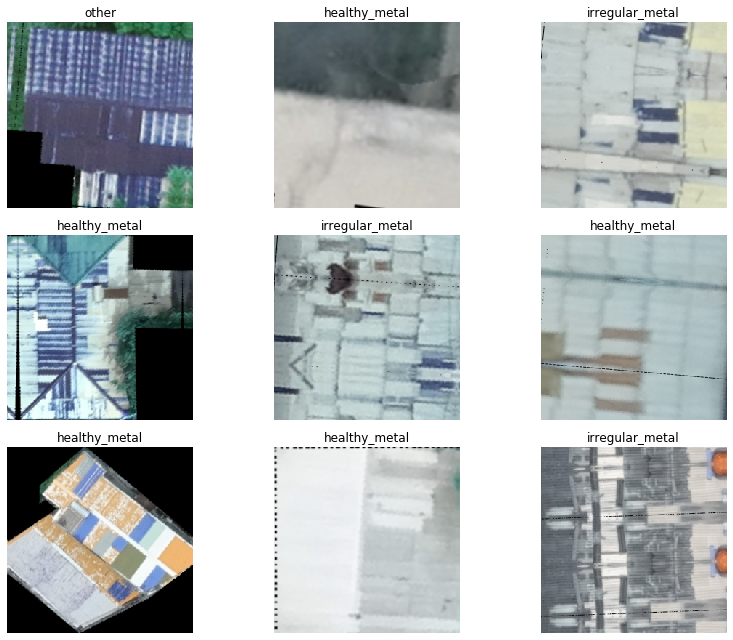

In [33]:
data.show_batch(rows=3, figsize=(12,9))

In [34]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

In [35]:
def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

### Model

In [36]:
m = ptcv_get_model("inceptionv4", pretrained=False)

In [37]:
def inceptionv4(pretrained=False):
    return ptcv_get_model("inceptionv4", pretrained=False).features

In [38]:
arch = inceptionv4
arch_name = 'inceptionv4'

In [39]:
learn = cnn_learner(data, arch, pretrained=False,
                    cut=noop, split_on=lambda m: (m[0][3], m[1]), metrics=error_rate).to_fp16()

In [40]:
get_groups(nn.Sequential(*learn.model[0], *learn.model[1]), learn.layer_groups)

Group 1: ['InceptInitBlock', 'Sequential', 'Sequential']
Group 2: ['Sequential', 'AvgPool2d']
Group 3: ['AdaptiveConcatPool2d', 'Flatten', 'BatchNorm1d', 'Dropout', 'Linear', 'ReLU', 'BatchNorm1d', 'Dropout', 'Linear']


In [41]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### train model

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Given input size: (1536x6x6). Calculated output size: (1536x-1x-1). Output size is too small

In [ ]:
learn.recorder.plot()

Then we can fit the head of our network.

In [52]:
lr = 3e-3

In [53]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.909826,2.531793,0.316408,02:42
1,0.967085,1.308132,0.363193,03:08
2,0.784759,nan,0.244789,03:05
3,0.605529,nan,0.203104,03:00
4,0.567419,nan,0.209313,02:25


In [ ]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [ ]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.440590,0.437038,0.159202,01:46
1,0.432092,0.479548,0.173836,01:45
2,0.412660,1.158782,0.143902,01:46
3,0.378972,0.381735,0.135477,01:45
4,0.360037,0.345250,0.124612,01:47


<pre>
epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.438103 	0.431031 	0.157428 	01:37
1 	0.413694 	0.500094 	0.179823 	01:38
2 	0.405334 	0.394548 	0.143902 	01:35
3 	0.400567 	0.368481 	0.135920 	01:35
4 	0.352880 	0.357799 	0.128381 	01:35
    </pre>

In [73]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [32]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    

In [33]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.344736,0.349004,0.125277,01:27
1,0.343708,0.355190,0.129047,01:15
2,0.351904,0.371296,0.131042,01:14
3,0.346994,0.346989,0.123947,01:14
4,0.323809,0.346372,0.126608,01:15


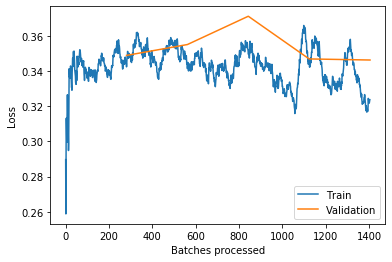

In [34]:
learn.recorder.plot_losses()

In [35]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [39]:
learn.export(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [72]:
learn.export()

### Larger size images

In [45]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

In [46]:
learn.freeze()

In [47]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 10.73 GiB total capacity; 8.32 GiB already allocated; 940.06 MiB free; 621.31 MiB cached)

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.087761,0.085013,0.958006,0.926066
2,0.087641,0.083732,0.958260,0.927459
3,0.084250,0.082856,0.958485,0.928200
4,0.082347,0.081470,0.960091,0.929166
5,0.078463,0.080984,0.959249,0.930089


In [ ]:
learn.save(f'stage-1-256-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.082938,0.083548,0.957846,0.927756
2,0.086312,0.084802,0.958718,0.925416
3,0.084824,0.082339,0.959975,0.930054
4,0.078784,0.081425,0.959983,0.929634
5,0.074530,0.080791,0.960426,0.931257


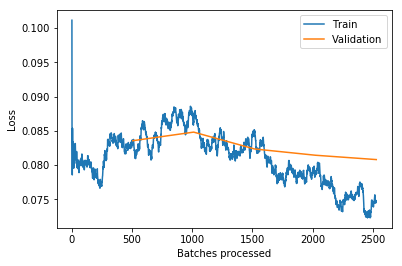

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save(f'stage-2-256-{arch_name}-{MODEL_NAME}-{DATE}-{UID})

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

### inference

In [73]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [74]:
len(test_dataset)

7325

In [88]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [89]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [90]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [91]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [92]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [94]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [95]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [96]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [97]:
labels = np.argmax(preds, 1)

In [98]:
len(preds)

7325

In [99]:
preds[0].tolist()

[0.03346812352538109,
 0.9584664702415466,
 0.0006572084967046976,
 0.006149182096123695,
 0.001259048469364643]

In [100]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [101]:
len(labels)

7325

In [102]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [103]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [104]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [105]:
test_predictions[0]

'healthy_metal'

In [106]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [107]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/256/7a486800.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4c49fc.tif'),
       PosixPath('data/test/rotated/clipped/256/7a501f50.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4d27b4.tif')], dtype=object)

In [108]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [109]:
preds_list[0]

[0.03346812352538109,
 0.9584664702415466,
 0.0006572084967046976,
 0.006149182096123695,
 0.001259048469364643]

In [110]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [111]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [112]:
df.head()

,id,pred
0,7a4d9168,"[0.03346812352538109, 0.9584664702415466, 0.00..."
1,7a4ae922,"[0.0044168452732264996, 0.8947269320487976, 0...."
2,7a48ca98,"[0.003338959999382496, 0.23377253115177155, 0...."
3,7a49c614,"[0.0004943751264363527, 0.8595386147499084, 0...."
4,7a4dd4f2,"[0.0005148547934368253, 0.9120095372200012, 0...."


In [113]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [114]:
pred_df.insert(loc=0, column='id', value=ids)

In [115]:
pred_df.columns = cols

In [116]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.033468,0.958466,0.000657,0.006149,0.001259
1,7a4ae922,0.004417,0.894727,0.002138,0.096884,0.001835
2,7a48ca98,0.003339,0.233773,0.013359,0.748489,0.001040
3,7a49c614,0.000494,0.859539,0.000788,0.138634,0.000545
4,7a4dd4f2,0.000515,0.912010,0.000831,0.081663,0.004982


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [138]:
pred_df = pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [139]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.033468,0.958466,0.000657,0.006149,0.001259
1,7a4ae922,0.004417,0.894727,0.002138,0.096884,0.001835
2,7a48ca98,0.003339,0.233773,0.013359,0.748489,0.001040
3,7a49c614,0.000494,0.859539,0.000788,0.138634,0.000545
4,7a4dd4f2,0.000515,0.912010,0.000831,0.081663,0.004982


In [149]:
pred_ids=pred_df['id'].values.tolist()

In [119]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [129]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [146]:
baseline_ids=df_baseline['id'].values.tolist()

In [147]:
baseline_ids

['7a4d630a',
 '7a4bbbd6',
 '7a4ac744',
 '7a4881fa',
 '7a4aa4a8',
 '7a514434',
 '7a485f72',
 '7a4b8d32',
 '7a47eb3c',
 '7a4be3ae',
 '7a46a330',
 '7a481620',
 '7a49c678',
 '7a4ea044',
 '7a47aa1e',
 '7a51aa1e',
 '7a498be0',
 '7a4a2848',
 '7a4c4cd6',
 '7a465038',
 '7a4e94aa',
 '7a49f62a',
 '7a45b6f0',
 '7a50bb90',
 '7a4d38e4',
 '7a48a3a6',
 '7a4ebe9e',
 '7a48352e',
 '7a4bfaec',
 '7a51e060',
 '7a4c0f5a',
 '7a4b9976',
 '7a4b27d4',
 '7a51c698',
 '7a474bb4',
 '7a480054',
 '7a4a4044',
 '7a4c35ca',
 '7a4d3fd8',
 '7a4c1a68',
 '7a4eb1c4',
 '7a4a51ce',
 '7a4a14fc',
 '7a5015d2',
 '7a4ba95c',
 '7a5101ae',
 '7a4d0a22',
 '7a5134ee',
 '7a4a85c2',
 '7a514b14',
 '7a4d0a90',
 '7a485fd6',
 '7a4f668c',
 '7a44e752',
 '7a5162d4',
 '7a465894',
 '7a4c9a10',
 '7a485810',
 '7a4a9788',
 '7a503198',
 '7a4e206a',
 '7a4c15ea',
 '7a4f8536',
 '7a513df4',
 '7a4d7624',
 '7a4c9e8e',
 '7a4b2554',
 '7a502b12',
 '7a4c32e6',
 '7a4a8a2c',
 '7a467b76',
 '7a51b554',
 '7a4622e8',
 '7a4a599e',
 '7a4d17c4',
 '7a4fb740',
 '7a4ceed4',

In [150]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [151]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [152]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.033468,0.958466,0.000657,0.006149,0.001259,7a4d9168
1,7a4ae922,0.004417,0.894727,0.002138,0.096884,0.001835,7a4ae922
2,7a48ca98,0.003339,0.233773,0.013359,0.748489,0.001040,7a48ca98
3,7a49c614,0.000494,0.859539,0.000788,0.138634,0.000545,7a49c614
4,7a4dd4f2,0.000515,0.912010,0.000831,0.081663,0.004982,7a4dd4f2


In [153]:
pred_df=pred_df.sort_values('id_cat')

In [154]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
716,7a4d630a,0.013808,0.980777,0.000303,0.003716,0.001395,7a4d630a
764,7a4bbbd6,0.000810,0.949852,0.000470,0.048376,0.000491,7a4bbbd6
1841,7a4ac744,0.001608,0.855418,0.001628,0.140389,0.000957,7a4ac744
3363,7a4881fa,0.004803,0.234743,0.006764,0.752769,0.000920,7a4881fa
133,7a4aa4a8,0.004477,0.706235,0.003069,0.283955,0.002263,7a4aa4a8


In [156]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [157]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [1]:
### Submission 2: 0.4461


In [16]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

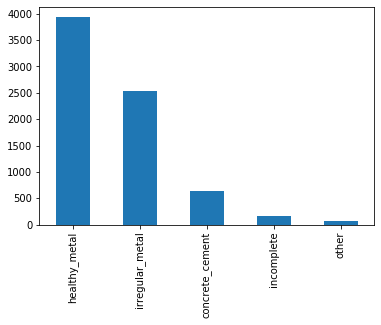

In [17]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")